In [1]:
%matplotlib inline
from config_calc import *

import matplotlib
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'

import cmocean
import plot_tools
import solubility

#dataroot = '/glade/p/ncgd0033/obs'
#dataroot = '/project/oce/mclong'
dataroot = '~/data'

### read woa data

In [2]:
mask_file_in = os.path.join(dataroot,'woa2013v2/1x1d/woa_region_mask.nc')
dsm = xr.open_dataset(mask_file_in)
dsm

<xarray.Dataset>
Dimensions:         (lat: 180, lon: 360, region: 5)
Coordinates:
  * lat             (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon             (lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
Dimensions without coordinates: region
Data variables:
    area            (lat, lon) float64 1.079e+08 1.079e+08 1.079e+08 ...
    mask            (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    kmt             (lat, lon) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    REGION_MASK_3D  (region, lat, lon) float64 nan nan nan nan nan nan nan ...
    region_names    (region) |S14 'Global' 'Pacific' 'Atlantic' 'Indian' ...

In [3]:
woapth = os.path.join(dataroot,'woa2013v2/1x1d')

woa_info = {
    'O2': {'varname': 'o_an', 'file' : os.path.join(woapth,'woa13_all_o00_01.nc')},   
    'PO4': {'varname': 'p_an', 'file' : os.path.join(woapth,'woa13_all_p00_01.nc')},   
    'NO3': {'varname': 'n_an', 'file' : os.path.join(woapth,'woa13_all_n00_01.nc')}}

woa = {}
for v,info in woa_info.items():   
    varname = info['varname']
    file_in = info['file']
    woai = xr.open_dataset(file_in,decode_times=False)
    woai = woai.drop([k for k in woai if k not in [varname,'lat','lon','depth','depth_bnds']])
    woai = woai.rename({varname:v})
    if woa:
        woa = xr.merge((woa,woai))
    else:
        woa = woai
         
ni = len(woa.lon)
nj = len(woa.lat)

mlperl_2_mmolm3 = 1.e6 / 1.e3 / 22.3916
for v in ['O2']:
    woa[v] = woa[v] * mlperl_2_mmolm3
    woa[v].attrs['units'] = 'mmol m$^{-3}$'

woa['dz'] = woa.depth_bnds[:,1] - woa.depth_bnds[:,0]         
woa = woa.isel(time=0)
woa

<xarray.Dataset>
Dimensions:     (depth: 102, lat: 180, lon: 360, nbounds: 2)
Coordinates:
  * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon         (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
  * depth       (depth) float32 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 ...
Dimensions without coordinates: nbounds
Data variables:
    depth_bnds  (depth, nbounds) float32 0.0 2.5 2.5 7.5 7.5 12.5 12.5 17.5 ...
    PO4         (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    O2          (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    NO3         (depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    dz          (depth) float32 2.5 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 ...

### mask out marginal seas

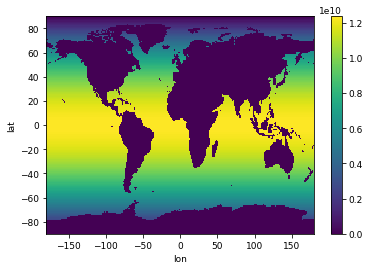

In [4]:
woa = woa.where(dsm.REGION_MASK_3D[0,:,:]==1)
area = dsm.area.where(dsm.REGION_MASK_3D[0,:,:]==1).fillna(0.)
area.plot()

In [5]:
nz = woa.depth.shape[0]
nlat = woa.lat.shape[0]
nlon = woa.lon.shape[0]
rmask = xr.DataArray(np.zeros((nz,nlat,nlon)),dims=('depth','lat','lon'))
rmask[:,:,:] = np.where(np.isnan(woa.O2), 0., 1.)
rmask

<xarray.DataArray (depth: 102, lat: 180, lon: 360)>
array([[[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 1.,  1., ...,  1.,  1.],
        [ 1.,  1., ...,  1.,  1.]],

       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 1.,  1., ...,  1.,  1.],
        [ 1.,  1., ...,  1.,  1.]],

       ..., 
       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]],

       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]]])
Dimensions without coordinates: depth, lat, lon

In [6]:
awgt =  rmask * area
awgt

<xarray.DataArray (depth: 102, lat: 180, lon: 360)>
array([[[  0.000000e+00,   0.000000e+00, ...,   0.000000e+00,   0.000000e+00],
        [  0.000000e+00,   0.000000e+00, ...,   0.000000e+00,   0.000000e+00],
        ..., 
        [  3.236782e+08,   3.236782e+08, ...,   3.236782e+08,   3.236782e+08],
        [  1.079037e+08,   1.079037e+08, ...,   1.079037e+08,   1.079037e+08]],

       [[  0.000000e+00,   0.000000e+00, ...,   0.000000e+00,   0.000000e+00],
        [  0.000000e+00,   0.000000e+00, ...,   0.000000e+00,   0.000000e+00],
        ..., 
        [  3.236782e+08,   3.236782e+08, ...,   3.236782e+08,   3.236782e+08],
        [  1.079037e+08,   1.079037e+08, ...,   1.079037e+08,   1.079037e+08]],

       ..., 
       [[  0.000000e+00,   0.000000e+00, ...,   0.000000e+00,   0.000000e+00],
        [  0.000000e+00,   0.000000e+00, ...,   0.000000e+00,   0.000000e+00],
        ..., 
        [  0.000000e+00,   0.000000e+00, ...,   0.000000e+00,   0.000000e+00],
        [  0.000000e

In [7]:
woaa = (woa*awgt).sum(dim=('lat','lon'))/awgt.sum(dim=('lat','lon'))
woaa

<xarray.Dataset>
Dimensions:     (depth: 102, nbounds: 2)
Coordinates:
  * depth       (depth) float64 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 ...
Dimensions without coordinates: nbounds
Data variables:
    depth_bnds  (depth, nbounds) float64 0.0 2.5 2.5 7.5 7.5 12.5 12.5 17.5 ...
    PO4         (depth) float64 0.5337 0.5348 0.5349 0.542 0.5487 0.5571 ...
    O2          (depth) float64 250.4 250.5 250.5 250.2 249.9 249.4 248.9 ...
    NO3         (depth) float64 5.259 5.269 5.326 5.393 5.479 5.602 5.753 ...
    dz          (depth) float64 2.5 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 5.0 ...

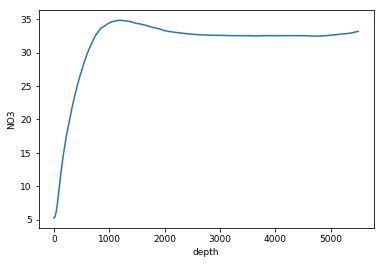

In [8]:
woaa.NO3.plot()

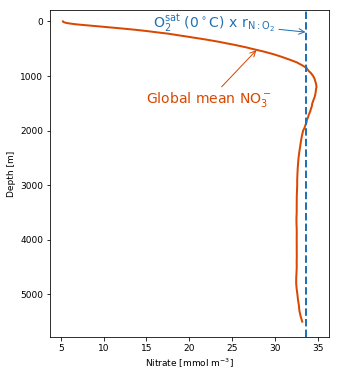

In [12]:
import colorbrewer

plot_name = os.path.join(diro['talk_fig'],'woa-no3-o2sat-profile.pdf')
                         
fig = plt.figure(figsize=(5,6))
ax = fig.add_subplot(1,1,1)

clr_no3 = colorbrewer.singlehue('orange')[2]
clr_o2 = colorbrewer.singlehue('blue')[2]

pn = ax.plot(woaa.NO3,woaa.depth,'-',color=clr_no3,linewidth=2)

x = 16./170*solubility.O2(35.,0)
ax.axvline(x,color=clr_o2,linestyle='--',linewidth=2)

ylm = ax.get_ylim()
ax.set_xlabel('Nitrate [mmol m$^{-3}$]')
ax.set_ylabel('Depth [m]')
ax.set_ylim(5775,-200)

ax.annotate('O$_2^{sat}$ (0$^\circ$C) x r$_{N:O_2}$', 
            xy=(33.8,200),
            xytext=(30,100),
            arrowprops=dict(color=clr_o2,arrowstyle='->'),
            horizontalalignment='right',
            color = clr_o2,
            fontsize = 14)

ax.annotate('Global mean NO$_3^-$', 
            xy=(28,500),
            xytext=(15,1500),
            arrowprops=dict(color=clr_no3,arrowstyle='->'),
            horizontalalignment='left',
            color = clr_no3,
            fontsize = 14)

plt.savefig(plot_name,bbox_inches='tight')